## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [56]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from tqdm import tqdm

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
file_path = "complaints.json"
with open(file_path, 'r') as f:
    data = json.load(f)
    
df = pd.json_normalize(data)

## Data preparation

### Inspect the dataframe to understand the given data.


In [3]:
df.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
df.shape

(78313, 22)

In [5]:
df['_index'].unique(), df['_type'].unique(), df['_id'].unique()

(array(['complaint-public-v2'], dtype=object),
 array(['complaint'], dtype=object),
 array(['3211475', '3229299', '3199379', ..., '3133355', '3110963',
        '2001189'], dtype=object))

In [6]:
only_one_value_cols = []
for column in df:
    if len(df[column].unique()) == 1:
        print(column, ":", df[column].unique())
        only_one_value_cols.append(column)

_index : ['complaint-public-v2']
_type : ['complaint']
_score : [0.]
_source.company : ['JPMORGAN CHASE & CO.']


In [7]:
for column in df:
    if len(df[column].unique()) == 2:
        print(column, ":", df[column].unique())

_source.timely : ['Yes' 'No']


In [8]:
for column in df:
    if len(df[column].unique()) == 3:
        print(column, ":", df[column].unique())

_source.consumer_disputed : ['N/A' 'No' 'Yes']


#### dropping columns with only one type of value

In [9]:
df.drop(columns=only_one_value_cols, inplace=True)

In [10]:
df.head(1)

,_id,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,3211475,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided


In [11]:
df.shape

(78313, 18)

In [12]:
len(df['_id'].unique())

78313

#### dropping id column as all values are different

In [13]:
df.drop('_id', axis=1, inplace=True)

In [14]:
df.head(1)

,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided


In [15]:
df.shape

(78313, 17)

In [16]:
# print the column names
df.columns.to_list()

['_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [17]:
#Assign new column names
df.rename(columns={'_source.tags':'tags',
'_source.zip_code':'zip_code',
'_source.complaint_id':'complaint_id',
'_source.issue':'issue',
'_source.date_received':'date_received',
'_source.state':'state',
'_source.consumer_disputed':'consumer_disputed',
'_source.product':'product',
'_source.company_response':'company_response',
'_source.submitted_via':'submitted_via',
'_source.date_sent_to_company':'date_sent_to_company',
'_source.company_public_response':'company_public_response',
'_source.sub_product':'sub_product',
'_source.timely':'timely',
'_source.complaint_what_happened':'complaint_what_happened',
'_source.sub_issue':'sub_issue',
'_source.consumer_consent_provided':'consumer_consent_provided'},
          inplace=True
)

In [18]:
df.columns.to_list()

['tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [19]:
for column in df:
    if len(df[column].unique()) > 10:
        print(column, ':', len(df[column].unique()))
        # print(column, ":", df[column].unique())

zip_code : 9443
complaint_id : 78313
issue : 154
date_received : 3444
state : 63
product : 17
date_sent_to_company : 3309
sub_product : 73
complaint_what_happened : 20931
sub_issue : 206


In [20]:
df.drop('complaint_id', inplace=True, axis=1)

In [21]:
df.shape

(78313, 16)

In [22]:
df.head(1)

,tags,zip_code,issue,date_received,state,consumer_disputed,product,company_response,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,None,90301,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided


In [23]:
print(df.columns.to_list())

['tags', 'zip_code', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']


In [24]:
# Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].head(3)

0                                                     
1    Good morning my name is XXXX XXXX and I apprec...
2    I upgraded my XXXX XXXX card in XX/XX/2018 and...
Name: complaint_what_happened, dtype: object

In [25]:
df['complaint_what_happened'].str.strip() == ''

0         True
1        False
2        False
3         True
4         True
         ...  
78308     True
78309    False
78310    False
78311    False
78312    False
Name: complaint_what_happened, Length: 78313, dtype: bool

In [26]:
# count tickets with actual complaints
sum(df['complaint_what_happened'].str.strip() == '')

57241

In [27]:
df['complaint_what_happened'].isna().sum()

0

In [28]:
df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [29]:
df['complaint_what_happened'].isna().sum()

57241

In [30]:
# Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened']).head(1)

,tags,zip_code,issue,date_received,state,consumer_disputed,product,company_response,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,Servicemember,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided


In [31]:
df.dropna(subset=['complaint_what_happened'], inplace=True)

In [32]:
df['complaint_what_happened'].isna().sum()

0

In [33]:
df.shape

(21072, 16)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [34]:
def preprocess_text(inp):
    # make the text lowercase
    # remove text in square brackets
    # remove punctuation
    # remove words containing numbers
    # remove \n
    inp = inp.lower()
    inp = re.sub("\[.*\]", "", inp).strip()
    inp = re.sub(r'[^\w\s]', '', inp).strip()
    inp = re.sub(r'\w*\d\w*', '', inp).strip()
    inp = re.sub(r'\n', '', inp).strip()
    
    return inp

In [35]:
df['complaint_what_happened'] = df['complaint_what_happened'].apply(preprocess_text)

In [36]:
df.reset_index(drop=True, inplace=True)

In [37]:
#Write your function to Lemmatize the texts
# nlp(df['complaint_what_happened'])
df['complaint_what_happened'][0]

'good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account  xxxx xxxx xxxx xxxx thanks in advance for your help'

In [38]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
x = nlp(df['complaint_what_happened'][0])

In [39]:
x[1], x[1].lemma_

(morning, 'morning')

In [40]:
z = lambda y: y.lemma_

In [41]:
def get_relevant_words(doc):
    lemmas = [] # should we use set? (keep unique)
    for token in doc:
        lemma = token.lemma_
        pos_tag = token.tag_
        
        # print(lemma, pos_tag)
        
        if "NN" in pos_tag:
            lemmas.append(lemma)
            
    return lemmas

In [64]:
lemmatizer = lambda doc: [token.lemma_ for token in doc]

In [51]:
# lemmatizer(x)

In [52]:
print(get_relevant_words(x))

['morning', 'name', 'xxxx', 'xxxx', 'stop', 'bank', 'cardmember', 'service', 'debt', 'verification', 'statement', 'bank', 'debt', 'mail', 'month', 'debt', 'right', 'information', 'consumer', 'chase', 'account', 'xxxx', 'xxxx', 'thank', 'advance', 'help']


In [53]:
#Write your function to extract the POS tags 
df_clean = pd.DataFrame(df['complaint_what_happened'])

In [82]:
df_clean['lemmatized_complaint'] = np.nan
df_clean['lemmatized_complaint'] = df_clean['lemmatized_complaint'].astype(str)

In [84]:
# df_clean.loc[0]['lemmatized_complaint']

In [114]:
#cnt = 0
#
#for index, row in tqdm(df.iterrows(), total=df.shape[0]):
#    cnt += 1
#    #docs = list(nlp.pipe(row['complaint_what_happned']))
#    lemmatized = lemmatizer(nlp.pipe(row['complaint_what_happened']))
#    df_clean.at[index, 'lemmatized_complaint'] = " ".join(lemmatized)
#    # print(" ".join(lemmatized))
#    if cnt > 10:
#        break
#   #print("index",index)
#   #print("row",row)

In [129]:
cnt = 0
for index, doc in enumerate(tqdm(nlp.pipe(df['complaint_what_happened'], 
                                          disable=["tok2vec", "parser", "ner"]), 
                                          total=df_clean.shape[0])):
#    cnt += 1
#    if cnt > 10:
#        break
    lemmatized = lemmatizer(doc)
    pos_tags = 
    df_clean.at[index, 'lemmatized_complaint'] = " ".join(lemmatized)

100%|█████| 21072/21072 [01:59<00:00, 175.61it/s]


In [130]:
df_clean.head(20)

,complaint_what_happened,lemmatized_complaint
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
1,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and was told...
2,chase card was reported on however fraudulent...,chase card was reported on however fraudulen...
3,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx tick...
4,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it ...
5,can you please remove inquiry,can you please remove inquiry
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...
7,during the summer months i experience a declin...,during the summer months i experience a declin...
8,on xxxx i made a payment to an online retail...,on xxxx i made a payment to an online reta...
9,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...


In [73]:
# df_clean['lemmatized'] = df_clean['complaint_what_happened'].apply(lemmatizer)

In [ ]:
df_clean.head()

In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
# df_clean

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length

In [108]:
pd.qcut(df_clean['complaint_what_happened'].str.len(), 5,)#labels=['lesser', 'less', 'average', 'more', 'morer'])
#.value_counts().plot(kind='bar')

0           (429.2, 747.4]
1          (-0.001, 429.2]
2          (-0.001, 429.2]
3         (1170.0, 1914.0]
4           (429.2, 747.4]
               ...        
21067       (429.2, 747.4]
21068    (1914.0, 30658.0]
21069    (1914.0, 30658.0]
21070    (1914.0, 30658.0]
21071      (747.4, 1170.0]
Name: complaint_what_happened, Length: 21072, dtype: category
Categories (5, interval[float64]): [(-0.001, 429.2] < (429.2, 747.4] < (747.4, 1170.0] < (1170.0, 1914.0] < (1914.0, 30658.0]]

The following 5 buckets can be formed such that all the buckets have equal number of sentences
- (-0.001, 429.2] 
- (429.2, 747.4] 
- (747.4, 1170.0] 
- (1170.0, 1914.0] 
- (1914.0, 30658.0]

In [109]:
pd.cut(df_clean['complaint_what_happened'].str.len(), 5,)#labels=['lesser', 'less', 'average', 'more', 'morer'])

0        (-30.658, 6131.6]
1        (-30.658, 6131.6]
2        (-30.658, 6131.6]
3        (-30.658, 6131.6]
4        (-30.658, 6131.6]
               ...        
21067    (-30.658, 6131.6]
21068    (-30.658, 6131.6]
21069    (-30.658, 6131.6]
21070    (-30.658, 6131.6]
21071    (-30.658, 6131.6]
Name: complaint_what_happened, Length: 21072, dtype: category
Categories (5, interval[float64]): [(-30.658, 6131.6] < (6131.6, 12263.2] < (12263.2, 18394.8] < (18394.8, 24526.4] < (24526.4, 30658.0]]

If we bucket by values, the following 5 intervals are formed
- (-30.658, 6131.6] 
- (6131.6, 12263.2] 
- (12263.2, 18394.8] 
- (18394.8, 24526.4] 
- (24526.4, 30658.0]]

<AxesSubplot:>

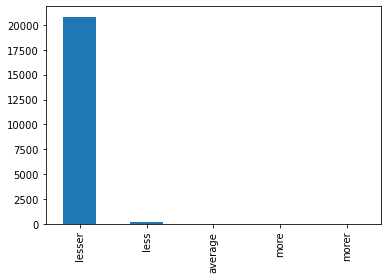

In [110]:
pd.cut(df_clean['complaint_what_happened'].str.len(), 5, labels=['lesser', 'less', 'average', 'more', 'morer']).value_counts().plot(kind='bar')

In [131]:
# We can see that most compl 

#### Find the top 40 words by frequency among all the articles after processing the text.

In [135]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
all_words_in_all_docs = " ".join(list(df_clean['lemmatized_complaint']))

In [136]:
all_words_list = all_words_in_all_docs.split(" ")

In [137]:
len(all_words_list)

5537219

In [142]:
#!pip install wordcloud

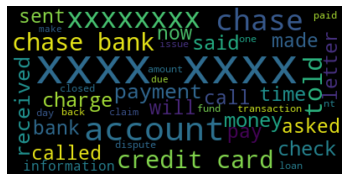

In [147]:
from wordcloud import WordCloud, STOPWORDS
# Start with one review:
#text = df_clean['lemmatized_complaint'][0]
text = " ".join(complaint for complaint in df_clean.lemmatized_complaint)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=40).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 


In [ ]:
#Print the top 10 words in the unigram frequency


In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 


In [ ]:
#Print the top 10 words in the bigram frequency

In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 


In [ ]:
#Print the top 10 words in the trigram frequency

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
df_clean

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [166]:
#Write your code here to initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [168]:
vect = TfidfVectorizer(stop_words='english')
X = vect.fit_transform(df_clean['lemmatized_complaint'])

df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())

In [169]:
df.head(2)

,aa,aaa,aaaratings,aaccounts,aacount,aaid,aall,aand,aaoa,aare,...,zipcodeaddress,zipped,zombie,zone,zoned,zones,zoo,zoom,zoomed,zthe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [171]:
from sklearn.decomposition import NMF

N_TOPICS = 15
nmf = NMF(n_components=N_TOPICS, init='nndsvd')
W = nmf.fit_transform(X)  # Document-topic matrix
H = nmf.components_       # Topic-term matrix

In [172]:
words = np.array(vect.get_feature_names())
topic_words = pd.DataFrame(np.zeros((N_TOPICS, 10)), index=[f'Topic {i + 1}' for i in range(N_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(10)]).astype(str)
for i in range(N_TOPICS):
    ix = H[i].argsort()[::-1][:10]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,xxxx,number,xxxxxxxxxxxx,address,complaint,office,chase,debt,case,contact
Topic 2,account,closed,checking,accounts,chase,opened,open,close,savings,reason
Topic 3,card,credit,chase,cards,score,limit,closed,accounts,applied,amazon
Topic 4,loan,mortgage,chase,modification,home,property,foreclosure,payments,years,rate
Topic 5,dispute,charge,chase,merchant,letter,received,refund,information,provided,sent
Topic 6,xxxxxxxx,received,letter,date,chase,called,told,dated,dates,statement
Topic 7,payment,late,payments,month,auto,chase,make,credit,pay,paid
Topic 8,check,funds,deposited,deposit,checks,cashed,cleared,hold,cash,days
Topic 9,charges,fraud,fraudulent,transactions,claim,card,transaction,debit,unauthorized,chase
Topic 10,fee,fees,overdraft,charged,annual,charge,insufficient,transactions,account,late


## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
# #Load your nmf_model with the n_components i.e 5
# num_topics = #write the value you want to test out
# 
# #keep the random_state =40
# nmf_model = #write your code here

In [ ]:
# nmf_model.fit(dtm)
len(tfidf.get_feature_names())

In [ ]:
#Print the Top15 words for each of the topics


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics





# References

- https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe
- https://www.kite.com/python/answers/how-to-use-regular-expressions-to-remove-text-within-parentheses-in-python
- https://stackoverflow.com/questions/18082130/python-regex-to-remove-all-words-which-contains-number
- https://spacy.io/api/lemmatizer
- https://stackoverflow.com/questions/47087741/use-tqdm-progress-bar-with-pandas
- https://spacy.io/usage/processing-pipelines
- https://spacy.io/usage/processing-pipelines#disabling